In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import os
import pysam
from Bio.Seq import Seq
import pyranges as pr
import rapidfuzz
import mappy as mp

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, Normalize

sys.path.append("../")
import utils as ut

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/demultiplex/Gridr1.putative_bc.csv"

df = pd.read_csv(fpath)
codes = dict(zip(df.read_id, df.putative_bc))
df.head()

,read_id,putative_bc,putative_bc_min_q,putative_umi,umi_end,pre_bc_flanking,post_umi_flanking
0,7ca01f6b-1455-4f05-ba7a-4b983ad8f534,NaN,NaN,NaN,NaN,NaN,NaN
1,ffa5cb0c-acb8-49b3-b0cb-9c757ec92615,GATAGAAGTACCAGAG,4.0,GCTAATGAGTAG,-104.0,GATCT,TTTTT
2,d49d4023-4d20-4e40-afdf-c691ac7e47e8,NaN,NaN,NaN,NaN,NaN,NaN
3,0f84e905-dfbf-4343-ac98-5a9a4d1c22ea,CCGCGAGTCATGAGTC,6.0,GGGACAGGTTAA,150.0,GATCT,TTTTT
4,13d4e220-ff2c-4c0e-aa40-afb93c5fa937,CGATGCGTCATGAGTC,17.0,CATGCTATGCGT,-98.0,GATCT,TTTTT


In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/fastq/Gridr1.raw.fastq.gz"
fastq = pysam.FastxFile(fpath)

stop = 10
count = -1
for read in fastq:
    count += 1
    if count == stop:
        break
        
    print(read.name)
    print(read.sequence)
    print()


7ca01f6b-1455-4f05-ba7a-4b983ad8f534
TTAACTGATTTCAATGGAGTGGGTGTTTTATGCAGTTCCATCATCTACCGTGACAAGAAAGTTGTCAGTGTCTTTGTGTTTCTGTTGGTGCTGATATTGCAAGCAGTGGTATCAACGCAGAGACATGGGGAAAATTTCATTTCAAATGCCAAAACCATCCTATAAAGAAAAACTTACCTTCTTAGGTCAAATCTCTAATATTTGACTAGATTCAAAAAGTTTATTTCTGGCCAGGCACAGTAGCTTACTCCTGAAATCCCAGCACTTTGGGAGACCAAGGTGGGAGGATCACTTGAGGCCAGGAATTCAAGACCAGCTTGAGCGACATAGCAAGACCCCATTTCTACAAAAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCTGGGGAGCTGCTCTCATCACAAGATCGGAAGAGCGTCGTGTAGGAAAGATAGAGCGACAGACGGAGTCTAAAGACACCGACAACTTTCTTGTCAT

ffa5cb0c-acb8-49b3-b0cb-9c757ec92615
AACATTGCTTCGTTCCGGTGCACTATGGTGATGGGTGTTTATGGATATCCTTCTGTGACAAGAAAGTTGTCGGTGTCTTTGTGTTTCTGTTGGTGCTGTCATTGCAAGCAGTGGTATCAACGCAGAGTACATGGGTAAATGAAAGATACAGCCAGGCGCTGGGCTCATGCTTGTAATCCCAGCACTTTGCGGGGCCAAGGCGGGCGGATCACGAGGTCAGGAGTTCAAGACCAGCCTGGCCAACATGGTGAAACCCCGTCTCTACTAAAAATACAAAAGTTAGCTGGGTGTGGTGATGGGCACCAGCTACTCAGGAGGCTGAGGCAGGAGAATTGTTTGAACCCGGGAAGCGGAGGTTGCAGTGAGCCGAGATTACACCATTGCACTCCAGCCTGGGCGACAGAGCAAGACTTACTTAAAGTAAGTAAGTAAGTCAGTCTCAAAAAAA

In [4]:
test_bc = "CCGCGAGTCATGAGTC"
test_bc_rev = str(Seq(test_bc).reverse_complement())
test_seq = "TGTACTTCGTTCAATTGTGTTAGGTGTTTAGCATGATTGTCGCCTACCGTGACAAGAAAGTTGTCGGTGTCTTTGTGACTTGCCTGTCGCTCTATCTTCCTACACGACGCTCTTCCAGATCTCCGCGAGTCATGAGTCGGGACAGGTTAATTTTTTTTTTTTTTTTTTTTTCACTACTCATAACAGTTTATTTTTTACTTTGTACAAAATACAAAAATGCAAATCCAAGGAGTACAGACCAGTAGTGACAGGCACACTGCACAACAGCAACCTTGTCTAGCAAGACAGGAGTTTTTAAATTTTATTTTAGTGAATACATGCATTATATGAAACAACGACAACAACAACAACAAAAACACAAAGAGGCTAGAGATTTCACCGTTTCTACCCCCAAAATAACGCTTGCTATCAAGACTTTGGAGGGGGATGGGGGAAAAGAATTTAAAAGGCAAATAATTTTTCATAAAAAGTAAAAGCTACCATAAAACATTTTTTCCCATGTACTCTGCGTTGATACCACTGCTTGCAATATCAGCACCAACAGAAAGACAAAGACACCGACAACTTTCTTGTCAC"

print(test_bc in test_seq)
print(test_bc_rev in test_seq)

True
False


# Count some bvarcodes

In [5]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/fastq/Gridr1.raw.fastq.gz"
fastq = pysam.FastxFile(fpath)


res = []

stop = 1000
count = -1
for read in fastq:
    count += 1
    if count == stop:
        break

    read_name = read.name
    seq = read.sequence

    barcode = codes[read_name]
    detect = str(barcode) in seq

    position = -1
    if detect:
        position = seq.find(str(barcode))

    # reverse complement
    if not barcode is np.nan:
        barcode_rc = str(Seq(barcode).reverse_complement())
        detect_rc = str(barcode_rc) in seq
    else:
        barcode_rc = np.nan
        detect_rc = False
    
    position_rc = -1
    if detect_rc:
        position_rc = seq.find(str(barcode_rc))
        

    row = {
        'read_name' : read_name,
        'barcode' : barcode,
        'barcode_rc' : barcode_rc,
        'detect' : detect,
        'detect_rc' : detect_rc,
        'position' : position,
        'position_rc' : position_rc,
        'seq_length' : len(seq),
        'seq' : seq,
    }

    res.append(row)

res = pd.DataFrame(res)
res.head()

,read_name,barcode,barcode_rc,detect,detect_rc,position,position_rc,seq_length,seq
0,7ca01f6b-1455-4f05-ba7a-4b983ad8f534,NaN,NaN,False,False,-1,-1,476,TTAACTGATTTCAATGGAGTGGGTGTTTTATGCAGTTCCATCATCT...
1,ffa5cb0c-acb8-49b3-b0cb-9c757ec92615,GATAGAAGTACCAGAG,CTCTGGTACTTCTATC,False,True,-1,479,571,AACATTGCTTCGTTCCGGTGCACTATGGTGATGGGTGTTTATGGAT...
2,d49d4023-4d20-4e40-afdf-c691ac7e47e8,NaN,NaN,False,False,-1,-1,856,ATGGCCTTCGTTCAATTAGGTAGGTGTTTGCTCGGACCGTAAACCT...
3,0f84e905-dfbf-4343-ac98-5a9a4d1c22ea,CCGCGAGTCATGAGTC,GACTCATGACTCGCGG,True,False,122,-1,576,TGTACTTCGTTCAATTGTGTTAGGTGTTTAGCATGATTGTCGCCTA...
4,13d4e220-ff2c-4c0e-aa40-afb93c5fa937,CGATGCGTCATGAGTC,GACTCATGACGCATCG,False,True,-1,266,352,ATCTTGTACTTCGTTCAATTTGGTAGGTGTTTATGAATAGCCATAC...


In [6]:
print(res['detect'].value_counts(normalize=True))
print()
print(res['detect_rc'].value_counts(normalize=True))

detect
True     0.518
False    0.482
Name: proportion, dtype: float64

detect_rc
False    0.636
True     0.364
Name: proportion, dtype: float64


<AxesSubplot: xlabel='position', ylabel='Count'>

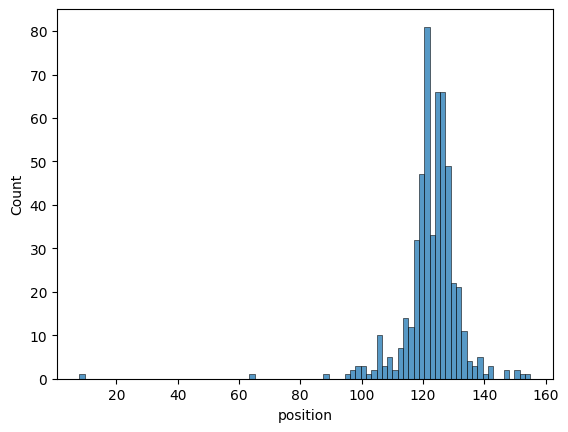

In [7]:
pdf = res[res['detect']]

sns.histplot(pdf['position'])

<AxesSubplot: xlabel='position_rc', ylabel='Count'>

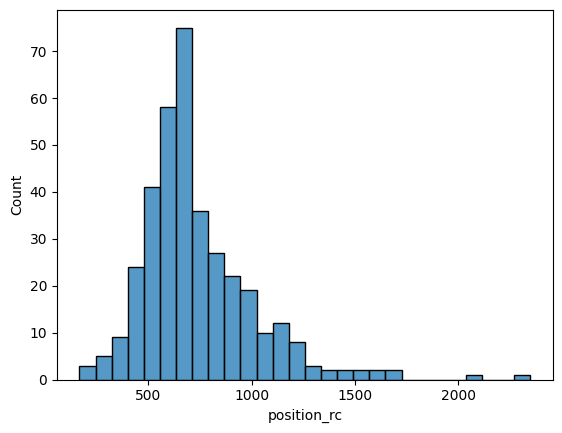

In [8]:
pdf = res[res['detect_rc']]
sns.histplot(pdf['position_rc'])

In [11]:
# write some test files
df['putative_bc'].value_counts()


putative_bc
GACAAGAAAGTTGTCG    3631
AGGTTACCAGTGTGGA    3374
GCCGTGAGTCTGGTTA    3246
CCCAACTGTAACATCC    3236
ATCGATGGTGGCATCC    3229
                    ... 
ACGCAATGAGAGTATC       1
GTGTTAGGGAGTATGG       1
CGAGGCTTGACTCAAT       1
TATTTTGTAGCAGCGG       1
TTTCAACGTCATTCCT       1
Name: count, Length: 3040399, dtype: int64

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Minimap 2 test

In [ ]:
# first, we need to build the reference fasta
fpath = open("barcodes.fasta", "w")

for i, barcode in enumerate(df['putative_bc'].unique()):
    if not barcode is np.nan:
        print(f">BC{i}", file=fpath)
        print(f"{barcode}", file=fpath)

print('done')

In [ ]:
import subprocess

def run_minimap2(sequence1_file, sequence2_file):
    # Command to run minimap2
    minimap2_command = f"minimap2 -x asm5 {sequence1_file} {sequence2_file}"
    
    # Execute the minimap2 command
    try:
        result = subprocess.run(minimap2_command, shell=True, check=True, capture_output=True, text=True)
        alignment_output = result.stdout
        return alignment_output
    except subprocess.CalledProcessError as e:
        print("Error running minimap2:", e)
        return None

In [ ]:
mdf = []
for idx, record in res.iterrows():
    seq = record['seq']
    for hit in a.map(seq):
        row = {
            'blen' : hit.blen,
            'cigar' : hit.cigar,
            'cigar_str' : hit.cigar_str,
            'cs' : hit.cs,
            'ctg' : hit.ctg,
            'ctg_len' : hit.ctg_len,
            'is_primary' : hit.is_primary,
            'mapq' : hit.mapq,
            'mlen' : hit.mlen,
            'q_en' : hit.q_en,
            'q_st' : hit.q_st,
            'r_en' : hit.r_en,
            'r_st' : hit.r_st,
            'read_num' : hit.read_num,
            'strand' : hit.strand,
            'trans_strand' : hit.trans_strand,   
        }

        mdf.append(row)

mdf = pd.DataFrame(mdf)
mdf.head()

# quick minimap2 test

In [ ]:
fpath = "../test.fa"
a = mp.Aligner(fpath, preset='map-ont', k=2)

for hit in a.map(test_bc):
    print(hit)